In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers,regularizers
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import numpy as np

In [ ]:
# Set all the Constants
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3
EPOCHS = 150
DROPOUT_RATE = 0.35
L2_LAMBDA = 0.001


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/plantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)


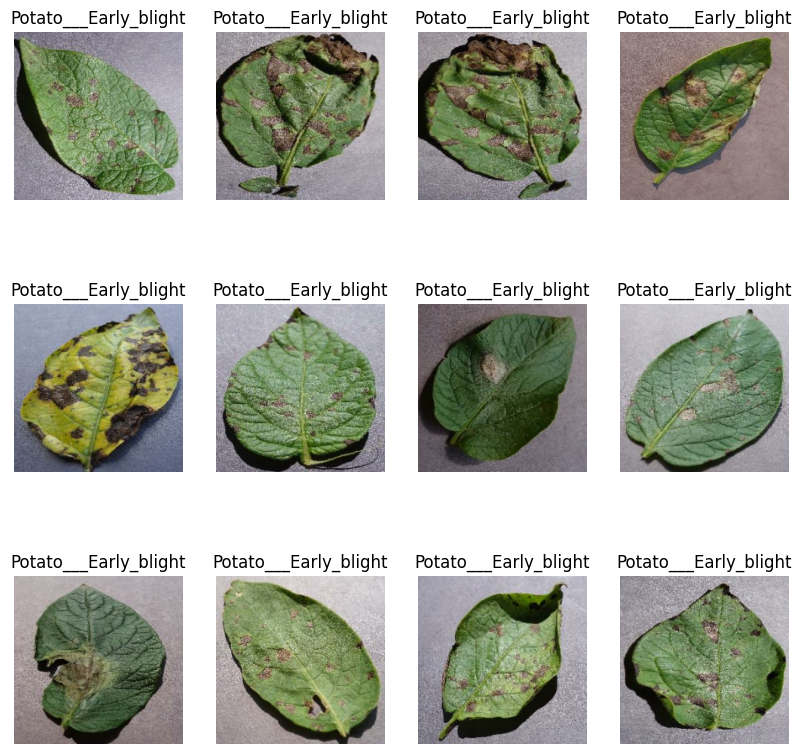

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax= plt.subplot(3, 4, i+1)# 3 and 4 represent 3*4 grid
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[0]])
        plt.axis("off")
        print(image_batch.shape)

In [ ]:
# Calculate the number of batches in the dataset
num_batches = tf.data.experimental.cardinality(dataset).numpy()

In [ ]:
# Calculate the number of batches for each set
train_batches = int(num_batches * 0.7)
val_batches = int(num_batches * 0.15)
test_batches = num_batches - train_batches - val_batches


In [ ]:
# Split the dataset into train, validation and test
train_ds = dataset.take(train_batches)
remaining_ds = dataset.skip(train_batches)
val_ds = remaining_ds.take(val_batches)
test_ds = remaining_ds.skip(val_batches)


In [ ]:
# Cache, Shuffle, and Prefetch the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
# Add more diverse data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2)
])


In [ ]:
# Resize and rescale images
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])


In [ ]:
# Simplify the model and add Dropout and L2 regularization
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(L2_LAMBDA), input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(DROPOUT_RATE),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(L2_LAMBDA)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(DROPOUT_RATE),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(L2_LAMBDA)),
    layers.Dropout(DROPOUT_RATE),
    layers.Dense(len(class_names), activation='softmax'),
])


In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [ ]:
# Add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)


In [ ]:
# Fit the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)


Epoch 1/150
47/47 [==============================] - 16s 196ms/step - loss: 3.3890 - accuracy: 0.4967 - val_loss: 1.2190 - val_accuracy: 0.6156
Epoch 2/150
47/47 [==============================] - 4s 88ms/step - loss: 1.0882 - accuracy: 0.6310 - val_loss: 1.1305 - val_accuracy: 0.7250
Epoch 3/150
47/47 [==============================] - 4s 86ms/step - loss: 0.8594 - accuracy: 0.7673 - val_loss: 0.8140 - val_accuracy: 0.8000
Epoch 4/150
47/47 [==============================] - 4s 84ms/step - loss: 0.7249 - accuracy: 0.8052 - val_loss: 0.8503 - val_accuracy: 0.6781
Epoch 5/150
47/47 [==============================] - 4s 90ms/step - loss: 0.6483 - accuracy: 0.8205 - val_loss: 0.6445 - val_accuracy: 0.8625
Epoch 6/150
47/47 [==============================] - 4s 85ms/step - loss: 0.5975 - accuracy: 0.8278 - val_loss: 0.4656 - val_accuracy: 0.8938
Epoch 7/150
47/47 [==============================] - 4s 84ms/step - loss: 0.5119 - accuracy: 0.8464 - val_loss: 0.4564 - val_accuracy: 0.9062
Epoc

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print("\nTest Accuracy:", test_acc)


11/11 - 5s - loss: 0.2225 - accuracy: 0.9665 - 5s/epoch - 454ms/step

Test Accuracy: 0.9664633870124817


In [ ]:
# Evaluate the model on the training dataset
train_loss, train_acc = model.evaluate(train_ds, verbose=2)
print("\nTrain Accuracy:", train_acc)

47/47 - 1s - loss: 0.2153 - accuracy: 0.9634 - 653ms/epoch - 14ms/step

Train Accuracy: 0.9634308218955994


In [ ]:
# Evaluate the model on the validation dataset
val_loss, val_acc = model.evaluate(val_ds, verbose=2)
print("\nValidation Accuracy:", val_acc)


10/10 - 0s - loss: 0.2069 - accuracy: 0.9656 - 142ms/epoch - 14ms/step

Validation Accuracy: 0.965624988079071


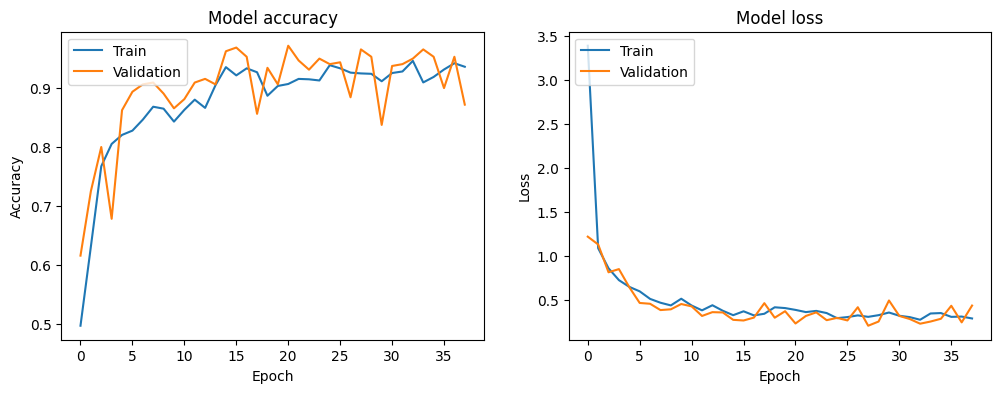

In [ ]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
# Calculate predictions on the test dataset
y_true = []
y_pred = []

for images_batch, labels_batch in test_ds:
    batch_predictions = model.predict(images_batch)
    batch_predictions = np.argmax(batch_predictions, axis=1)
    y_pred.extend(batch_predictions)
    y_true.extend(labels_batch.numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate and print the metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro',zero_division=1)
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

1/1 [==============================] - 0s 26ms/step
Accuracy: 0.9664634146341463
Precision: 0.9616030641647338
Recall: 0.9372401745819468
F1 Score: 0.9486176123370565


In [ ]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
                       precision    recall  f1-score   support

Potato___Early_blight       0.99      0.97      0.98       158
 Potato___Late_blight       0.95      0.98      0.96       148
     Potato___healthy       0.95      0.86      0.90        22

             accuracy                           0.97       328
            macro avg       0.96      0.94      0.95       328
         weighted avg       0.97      0.97      0.97       328



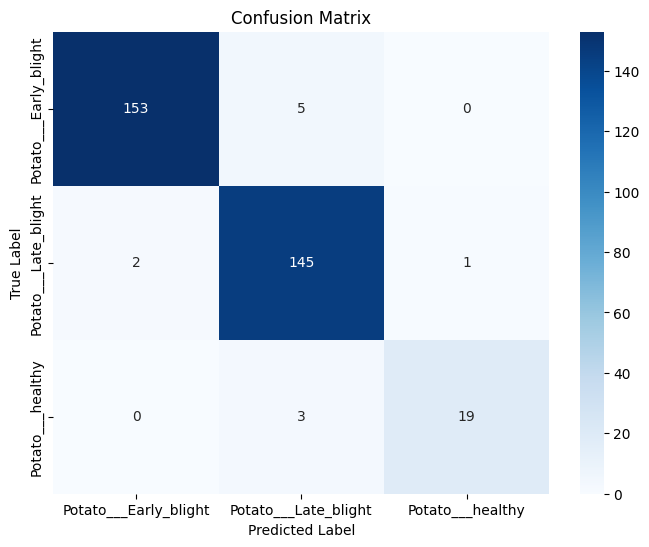

In [ ]:
# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 26ms/step
predicted label: Potato___Early_blight


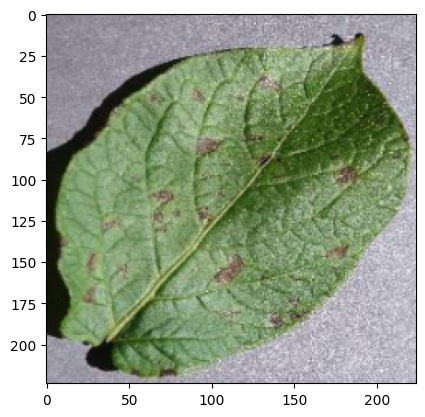

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

11/11 [==============================] - 0s 16ms/step


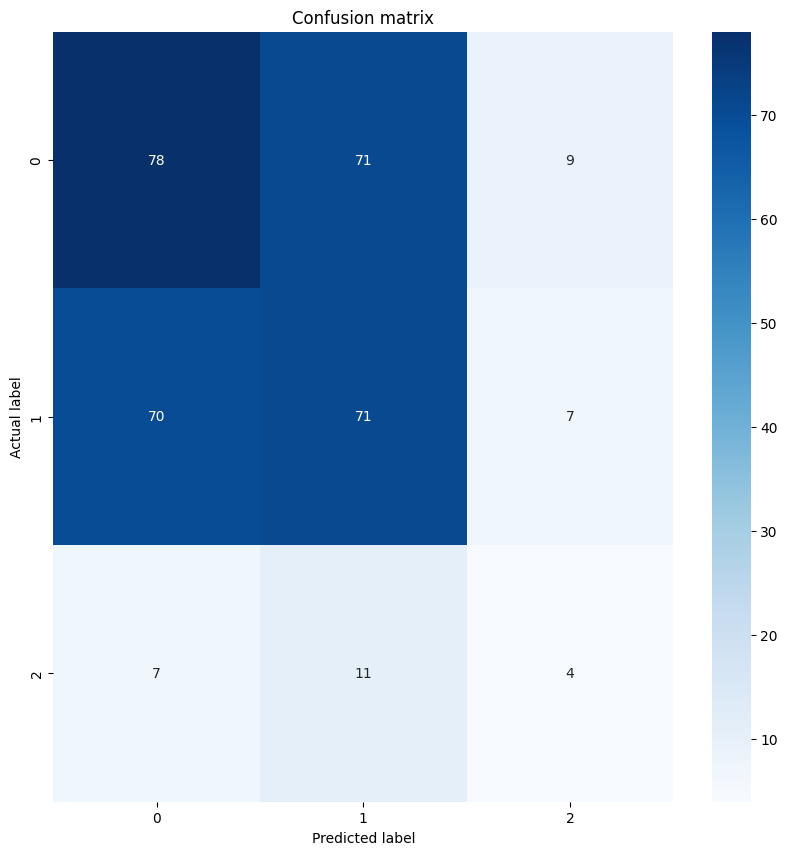

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the model's predictions on the test set
predictions = model.predict(test_ds)

# Convert the predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class labels
true_classes = []
for images, labels in test_ds:
    true_classes.extend(labels.numpy())
true_classes = np.array(true_classes)

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()